In [4]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
plt.style.use(hep.style.ROOT)

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

## Wcb Ana

In [4]:
# Load samples
df0 = {}
df0["ttbarsl"] = uproot.lazy(["/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_YZ_ntuple.root", "/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_FJ_ntuple_id0-499.root"])[1100000:] # exclude training samples
df0["wjets"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/WJetsToLNu_HT150_ntuple_id0-999.root")[1100000:] # exclude training samples
df0["wwsl"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/WWSL_ntuple_id0-99.root")
df0["twsl"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/TWSL_ntuple_id0-99.root")
df0["wjets_nocut"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/WJetsToLNu_ntuple_id0-99.root")

df0["ttbarsl_wcb"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_WToCB_FJ_ntuple_id0-24.root")
df0["twsl_wcb"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/TWSL_WToCB_ntuple_id0-24.root")
df0["wwsl_wcb"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/WWSL_WToCB_ntuple_id0-24.root")

# total lumi for Run2 + Run3
lumi_tot = 450 # fb-1

# compute weights from un-selected events
weights = {
    "ttbarsl": (lumi_tot / 100.) * 2250000 / len(df0["ttbarsl"]), # number of events passing 1 fj selection
    "wjets": (lumi_tot / 100.) * 6290000 / len(df0["wjets"]), # number of events passing 1 fj selection
    "wwsl": (lumi_tot / 100.) * 1615000 / len(df0["wwsl"]),
    "twsl": (lumi_tot / 100.) * 1108000 / len(df0["twsl"]),
    "wjets_nocut": (lumi_tot / 100.) * 1802000000 / len(df0["wjets_nocut"]),
    "ttbarsl_wcb": (lumi_tot / 100.) * 2250000 * 0.0008398 / len(df0["ttbarsl_wcb"]), # number of events passing 1 fj selection
    "wwsl_wcb": (lumi_tot / 100.) * 1615000 * 0.0008398 / len(df0["wwsl_wcb"]),
    "twsl_wcb": (lumi_tot / 100.) * 1108000 * 0.0008398 / len(df0["twsl_wcb"]),
}
print({sam: len(df0[sam]) for sam in df0})
print(weights)

# {'ttbarsl': 2570425, 'wjets': 4157131, 'wwsl': 2198372, 'twsl': 1803005, 'wjets_nocut': 2758550}
# {'ttbarsl': 0.8753416263847418, 'wjets': 1.513062734852474, 'wwsl': 0.7346345386495098, 'twsl': 0.6145296324746742, 'wjets_nocut': 653.2417393195701}

{'ttbarsl': 2716143, 'wjets': 4841933, 'wwsl': 2198372, 'twsl': 1803005, 'wjets_nocut': 2758550, 'ttbarsl_wcb': 61364, 'twsl_wcb': 453551, 'wwsl_wcb': 551420}
{'ttbarsl': 3.7277124216213946, 'wjets': 5.8458057969823205, 'wwsl': 3.305855423922794, 'twsl': 2.765383346136034, 'wjets_nocut': 2939.587826938065, 'ttbarsl_wcb': 0.1385661788670882, 'wwsl_wcb': 0.01106823564614994, 'twsl_wcb': 0.00923213221886844}


In [5]:
def _get_p4_from_index(_df, obj_str, idx):
    return _p4_from_ptetaphie(
        getattr(_df, obj_str + '_pt')[ak.singletons(idx)][:, 0],
        getattr(_df, obj_str + '_eta')[ak.singletons(idx)][:, 0],
        getattr(_df, obj_str + '_phi')[ak.singletons(idx)][:, 0],
        getattr(_df, obj_str + '_energy')[ak.singletons(idx)][:, 0],
    )
btag_wp = {"L": 0.0557, "M": 0.297, "T": 0.725}
ftag_wp = {"T_b1": 0.8493, "T_b2": 0.5881, "T_c1": 0.7574, "T_c2": 0.2963}

# new variables and selections
df = {}
for sam in df0:
    # fajet selections
    df[sam] = df0[sam][ak.num(df0[sam].fj_pt) > 0]
    d = df[sam]

    # fatjet sophon discr
    df[sam]["fj_sophon_discr"] = d.fj_sophon_probXbc / (d.fj_sophon_probXbc + d.fj_sophon_probQCD)
    df[sam]["fj_sophon_discr2"] = d.fj_sophon_probXbc / (d.fj_sophon_probXbc + d.fj_sophon_probXbq + d.fj_sophon_probXcs + d.fj_sophon_probXbqq + d.fj_sophon_probQCD)

    # fatjet candidate
    df[sam]["fjcand_p4"] = _get_p4_from_index(d, "fj", np.zeros(len(d), dtype=int))
    df[sam]["fjcand_sdmass"] = d.fj_sdmass[:,0]

    # fatjet candidate-m (with largest Sophon discr)
    df[sam]["fjcandm_idx"] = ak.argmax(d.fj_sophon_discr, axis=1)
    df[sam]["fjcandm_p4"] = _get_p4_from_index(d, "fj", d.fjcandm_idx)
    df[sam]["fjcandm_sdmass"] = d.fj_sdmass[ak.singletons(d.fjcandm_idx)][:, 0]
    
    df[sam]["fjcandm2_idx"] = ak.argmax(d.fj_sophon_discr2, axis=1)
    df[sam]["fjcandm2_p4"] = _get_p4_from_index(d, "fj", d.fjcandm2_idx)
    df[sam]["fjcandm2_sdmass"] = d.fj_sdmass[ak.singletons(d.fjcandm2_idx)][:, 0]

    # obj p4
    df[sam]["jet_p4"] = _p4_from_ptetaphie(d.jet_pt, d.jet_eta, d.jet_phi, d.jet_energy)
    df[sam]["lep_p4"] = _p4_from_ptetaphie(d.lep_pt, d.lep_eta, d.lep_phi, d.lep_energy)
    zeros = ak.zeros_like(d.lep_pt)
    df[sam]["met_p4"] = _p4_from_ptetaphim(d.met_pt, zeros, d.met_phi, zeros) # note: this is ptetaphim!

    ## select exclusive LP b jets (for Yuzhe's workflow)
    df[sam]["extbtagMPjet_p4"] = d.jet_p4[(d.jet_sophonAK4_probB > btag_wp["M"]) & (d.jet_p4.deltaR(d.fjcand_p4) > 0.8)]

    extbtagMPjet_12_pair = ak.combinations(d.extbtagMPjet_p4[:, :2], 2)
    df[sam]["dr_extbtagMPjet_12"] = ak.fill_none(ak.firsts(extbtagMPjet_12_pair['0'].deltaR(extbtagMPjet_12_pair['1'])), -1)
    df[sam]["dr_extbtagMPjet_12_fjcand_min"] = ak.fill_none(ak.firsts(
        np.minimum(extbtagMPjet_12_pair['0'].deltaR(d.fjcand_p4), extbtagMPjet_12_pair['1'].deltaR(d.fjcand_p4))
    ), 99.)

    # select MP b jets (for ParticleNetSFs workflow)
    df[sam]["btagMPjet_p4"] = d.jet_p4[d.jet_sophonAK4_probB > btag_wp["M"]]
    df[sam]["dr_btagMPjet_lep_min"] = ak.fill_none(ak.min(d.btagMPjet_p4.deltaR(d.lep_p4), axis=1), 99.)
    df[sam]["dr_lep_fjcand"] = d.lep_p4.deltaR(d.fjcand_p4)
    df[sam]["lepmet_pt"] = (d.lep_p4 + d.met_p4).pt

    # genpart p4 and matchings
    if 'wjets' not in sam:
        df[sam]["whad_idx"] = ak.fill_none(ak.argmax((np.abs(d.genpart_pid[:, :-1]) == 24) & (np.abs(d.genpart_pid[:, 1:]) <= 5), axis=1), 0)

        df[sam]["whad_p4"] = _get_p4_from_index(d, "genpart", d.whad_idx)
        df[sam]["whad_dau1_p4"] = _get_p4_from_index(d, "genpart", d.whad_idx + 1)
        df[sam]["whad_dau2_p4"] = _get_p4_from_index(d, "genpart", d.whad_idx + 2)
        df[sam]["whad_dau1_pid"] = d.genpart_pid[ak.singletons(d.whad_idx + 1)][:, 0]
        df[sam]["whad_dau2_pid"] = d.genpart_pid[ak.singletons(d.whad_idx + 2)][:, 0]

        # if whad follows a b quark, it is from a thad
        df[sam]["thad_b_idx"] = ak.where(
            np.abs(d.genpart_pid[ak.singletons(np.maximum(d.whad_idx - 1, 0))][:, 0]) == 5,
            d.whad_idx - 1,
            -1,
        )
        df[sam]["thad_b_p4"] = _get_p4_from_index(d, "genpart", d.thad_b_idx)

        # check matching criteria
        b_matched = (d.thad_b_idx >= 0) & (d.fjcand_p4.deltaR(d.thad_b_p4) < 0.8)
        wdau1_matched = d.fjcand_p4.deltaR(d.whad_dau1_p4) < 0.8
        wdau2_matched = d.fjcand_p4.deltaR(d.whad_dau2_p4) < 0.8
        df[sam]["is_t_matched"] = b_matched & wdau1_matched & wdau2_matched
        df[sam]["is_w_matched"] = ~b_matched & wdau1_matched & wdau2_matched
        df[sam]["is_tbc_matched"] = (b_matched & (wdau1_matched & (np.abs(d.whad_dau1_pid) == 4)) & ~wdau2_matched) | \
                                     (b_matched & (wdau2_matched & (np.abs(d.whad_dau2_pid) == 4)) & ~wdau1_matched)
        df[sam]["is_tbq_matched"] = (b_matched & (wdau1_matched & (np.abs(d.whad_dau1_pid) != 4)) & ~wdau2_matched) | \
                                     (b_matched & (wdau2_matched & (np.abs(d.whad_dau2_pid) != 4)) & ~wdau1_matched)
        df[sam]["is_non_matched"] = ~d.is_t_matched & ~d.is_w_matched & ~d.is_tbc_matched & ~d.is_tbq_matched

    # infer event DNN scores
    # _df = uproot.lazy(f'/home/olympus/licq/hww/incl-train/weaver-core/weaver/pheno/predict/wcb_boosted_evtobj.noweights.nobj8/pred_{sam}.root')
    # _df = uproot.lazy(f'/home/olympus/licq/hww/incl-train/weaver-core/weaver/pheno/predict/wcb_boosted_evtobj_ftagcat.noweights.nobj8/pred_{sam}.root')
    _df = uproot.lazy(f'/home/pku/zhaoyz/pheno/notebooks/files/wcb_boosted_evtobj_ftagcat_wtmatch.noweights.nobj8/pred_{sam}.root')
    for b in ["score_is_w_matched", "score_is_tbQ_matched", "score_is_non_matched", "score_is_wjets"]:
        df[sam][b] = _df[b]
    
    # custom flavour tagging
    df[sam]["jet_ftag_B1"] = d.jet_sophonAK4_probB > ftag_wp["T_b1"]
    df[sam]["jet_ftag_B2"] = (d.jet_sophonAK4_probB > ftag_wp["T_b2"]) & ~d.jet_ftag_B1
    df[sam]["jet_ftag_C1"] = (d.jet_sophonAK4_probC > ftag_wp["T_c1"]) & ~d.jet_ftag_B1 & ~d.jet_ftag_B2
    df[sam]["jet_ftag_C2"] = (d.jet_sophonAK4_probC > ftag_wp["T_c2"]) & ~d.jet_ftag_B1 & ~d.jet_ftag_B2 & ~d.jet_ftag_C1
    df[sam]["jet_ftag_N"] = ~d.jet_ftag_B1 & ~d.jet_ftag_B2 & ~d.jet_ftag_C1 & ~d.jet_ftag_C2

    ## correct is_wcb
    # if sam == 'ttbarsl':
    #     df[sam]['is_wcb'] = ak.any(np.abs(df[sam].genpart_pid[:, [3,4,8,9]]) == 5, axis=1)
    # elif sam == 'wjets':
    #     df[sam]['is_wcb'] = np.zeros(len(df[sam]), dtype=bool)

print({sam: len(df[sam]) for sam in df})

{'ttbarsl': 2500119, 'wjets': 4552037, 'wwsl': 134177, 'twsl': 243680, 'wjets_nocut': 9591, 'ttbarsl_wcb': 56597, 'twsl_wcb': 59330, 'wwsl_wcb': 32796}


In [6]:
# Categories
from types import SimpleNamespace
config = SimpleNamespace(
    categories = { # category name: (sample list, selection, label, color)
        "bkg_wjets": (["wjets"], "d.lep_pt > 0", r"Bkg: W+jets", "lightcyan"),
        "bkg_t_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_t_matched", r"Bkg ($t_{bqq'}$)", "blue"),
        "bkg_w_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_w_matched", r"Bkg ($W_{qq'}$)", "red"),
        "bkg_tbc_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbc_matched", r"Bkg ($t_{bc}$)", "orange"),
        "bkg_tbq_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbq_matched", r"Bkg ($t_{bq'}$)", "wheat"),
        "bkg_non_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_non_matched", r"Bkg (non)", "lightyellow"),

        # signals
        "sig_t_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_t_matched", r"Sig ($t_{bqq'}$)", "blue"),
        "sig_w_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_w_matched", r"Sig ($W_{qq'}$)", "red"),
        "sig_tbc_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_tbc_matched", r"Sig ($t_{bc}$)", "orange"),
        "sig_tbq_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_tbq_matched", r"Sig ($t_{bq'}$)", "wheat"),
        "sig_non_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_non_matched", r"Sig (non)", "lightyellow"),

        # optional signals
        # "sig_ttbarsl_t_matched": (["ttbarsl_wcb"], "d.is_wcb & d.is_t_matched", r"Sig $t\overline{t}$(SL) ($t_{bqq'}$)", "blue"),
        # "sig_ttbarsl_w_matched": (["ttbarsl_wcb"], "d.is_wcb & d.is_w_matched", r"Sig $t\overline{t}$(SL) ($W_{qq'}$)", "red"),
        # "sig_ttbarsl_tbc_matched": (["ttbarsl_wcb"], "d.is_wcb & d.is_tbc_matched", r"Sig $t\overline{t}$(SL) ($t_{bc}$)", "orange"),
        # "sig_ttbarsl_tbq_matched": (["ttbarsl_wcb"], "d.is_wcb & d.is_tbq_matched", r"Sig $t\overline{t}$(SL) ($t_{bq'}$)", "wheat"),
        # "sig_ttbarsl_non_matched": (["ttbarsl_wcb"], "d.is_wcb & d.is_non_matched", r"Sig $t\overline{t}$(SL) (non)", "lightyellow"),
        # "sig_wwsl_t_matched": (["wwsl_wcb"], "d.is_wcb & d.is_t_matched", r"Sig WW(SL) ($t_{bqq'}$)", "blue"),
        # "sig_wwsl_w_matched": (["wwsl_wcb"], "d.is_wcb & d.is_w_matched", r"Sig WW(SL) ($W_{qq'}$)", "red"),
        # "sig_wwsl_tbc_matched": (["wwsl_wcb"], "d.is_wcb & d.is_tbc_matched", r"Sig WW(SL) ($t_{bc}$)", "orange"),
        # "sig_wwsl_tbq_matched": (["wwsl_wcb"], "d.is_wcb & d.is_tbq_matched", r"Sig WW(SL) ($t_{bq'}$)", "wheat"),
        # "sig_wwsl_non_matched": (["wwsl_wcb"], "d.is_wcb & d.is_non_matched", r"Sig WW(SL) (non)", "lightyellow"),
        # "sig_twsl_t_matched": (["twsl_wcb"], "d.is_wcb & d.is_t_matched", r"Sig tW(SL) ($t_{bqq'}$)", "blue"),
        # "sig_twsl_w_matched": (["twsl_wcb"], "d.is_wcb & d.is_w_matched", r"Sig tW(SL) ($W_{qq'}$)", "red"),
        # "sig_twsl_tbc_matched": (["twsl_wcb"], "d.is_wcb & d.is_tbc_matched", r"Sig tW(SL) ($t_{bc}$)", "orange"),
        # "sig_twsl_tbq_matched": (["twsl_wcb"], "d.is_wcb & d.is_tbq_matched", r"Sig tW(SL) ($t_{bq'}$)", "wheat"),
        # "sig_twsl_non_matched": (["twsl_wcb"], "d.is_wcb & d.is_non_matched", r"Sig tW(SL) (non)", "lightyellow"),

    },

    variables = {
        "n_fj": ("ak.num(d.fj_pt)", bh.axis.Regular(5, 0, 5)),
        "fjcand_pt": ("d.fjcand_p4.pt", bh.axis.Regular(50, 0, 500)),
        "fjcand_eta": ("d.fjcand_p4.eta", bh.axis.Regular(50, -5, 5)),
        "fjcand_mass": ("d.fjcand_p4.mass", bh.axis.Regular(50, 0, 250)),
        "fjcand_sdmass": ("d.fjcand_sdmass", bh.axis.Regular(50, 0, 250)),
        "fjcand_sdmass_bw10": ("d.fjcand_sdmass", bh.axis.Regular(25, 0, 250)),
        "fjcandm_sdmass_bw10": ("d.fjcandm_sdmass", bh.axis.Regular(25, 0, 250)),
        "fjcand_sophon_discr": ("d.fj_sophon_discr[:,0]", bh.axis.Regular(100, 0., 1)),
        "fjcand_sophon_discr2": ("d.fj_sophon_discr2[:,0]", bh.axis.Regular(100, 0., 1)),
        "fjcand_sophon_discr_custom": ("d.fj_sophon_probXbc[:,0] / (d.fj_sophon_probXbc[:,0] + d.fj_sophon_probXbq[:,0] + d.fj_sophon_probXcs[:,0] + d.fj_sophon_probXqq[:,0] + d.fj_sophon_probXbqq[:,0])", bh.axis.Regular(100, 0.5, 1)),
        "lep_pt": ("d.lep_pt", bh.axis.Regular(50, 0, 500)),
        "lep_eta": ("d.lep_eta", bh.axis.Regular(50, -5, 5)),
        "n_extbtagMPjet": ("ak.num(d.extbtagMPjet_p4)", bh.axis.Regular(6, 0, 6)),
        # "n_extbtagMPjet": ("ak.num(d.jet_p4[(d.jet_sophonAK4_probB > 0.297) & (d.jet_p4.deltaR(d.fjcand_p4) > 0.8)])", bh.axis.Regular(6, 0, 6)),
        "n_extjet": ("ak.num(d.jet_p4[(d.jet_p4.deltaR(d.fjcand_p4) > 0.8)])", bh.axis.Regular(10, 0, 10)),
        "n_cleanjet": ("ak.num(d.jet_p4[(d.jet_p4.deltaR(d.fjcand_p4) > 0.8) & (d.jet_p4.deltaR(d.lep_p4) > 0.4)])", bh.axis.Regular(10, 0, 10)),
        "evt_dnn_score": ("d.score_is_w_matched", bh.axis.Regular(50, 0, 1)),
        "evt_dnn_score_tonly": ("d.score_is_w_matched / (1 - d.score_is_wjets)", bh.axis.Regular(50, 0, 1)),
        "dr_extbtagMPjet_12_fjcand_min": ("d.dr_extbtagMPjet_12_fjcand_min", bh.axis.Regular(30, 0, 6)),
    },

    signal_mul_factor = 10,
)
# btag_wp = {"L": 0.0557, "M": 0.297, "T": 0.725}


In [7]:
# cached df
dfc = {}
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        d = df[sam]
        dfc[(cname, sam)] = df[sam][eval(sel)]

## Plotting

Selection: (d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)
Variable: d.score_is_w_matched
Processing bkg_wjets wjets
Processing bkg_t_matched ttbarsl
Processing bkg_t_matched wwsl
Processing bkg_t_matched twsl
Processing bkg_w_matched ttbarsl
Processing bkg_w_matched wwsl
Processing bkg_w_matched twsl
Processing bkg_tbc_matched ttbarsl
Processing bkg_tbc_matched wwsl
Processing bkg_tbc_matched twsl
Processing bkg_tbq_matched ttbarsl
Processing bkg_tbq_matched wwsl
Processing bkg_tbq_matched twsl
Processing bkg_non_matched ttbarsl
Processing bkg_non_matched wwsl
Processing bkg_non_matched twsl
Processing sig_t_matched ttbarsl_wcb
Processing sig_t_matched wwsl_wcb
Processing sig_t_matched twsl_wcb
Processing sig_w_matched ttbarsl_wcb
Processing sig_w_matched wwsl_wcb
Processing sig_w_matched twsl_wcb
Processing sig_tbc_matched ttbarsl_wcb
Processing sig_tbc_matched wwsl_wcb
Processing sig_tbc_matched twsl_wcb
Processing sig_tbq_matched ttbarsl_wcb
Processing sig_tbq_mat

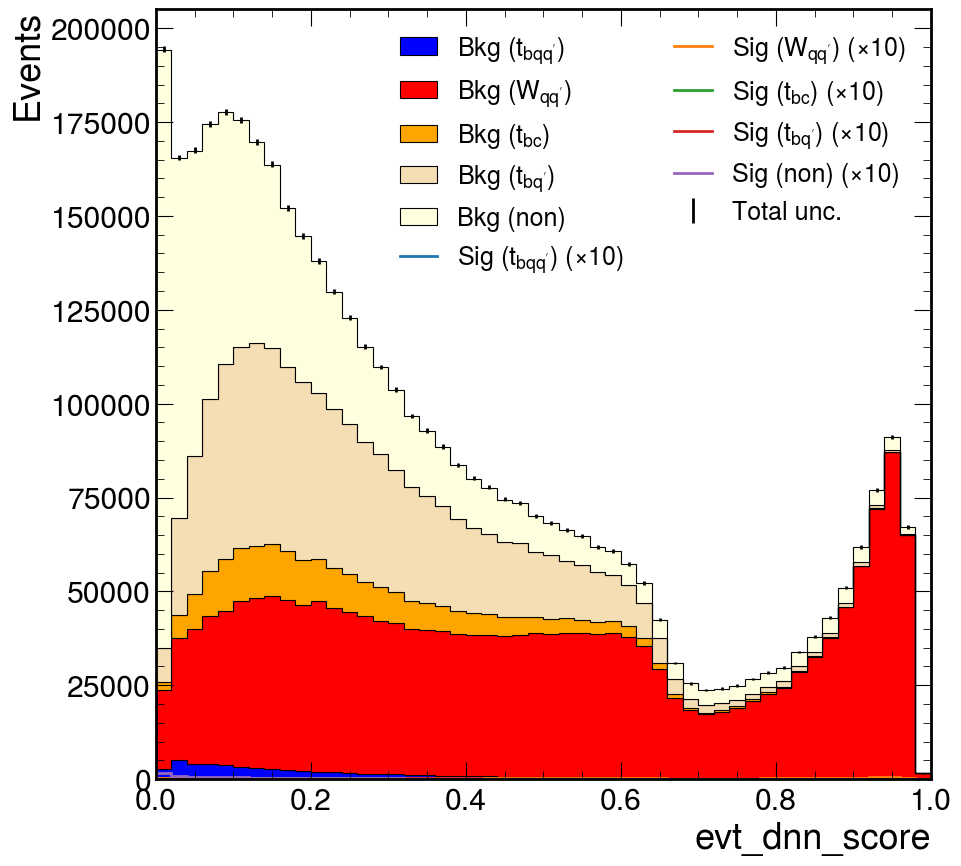

In [8]:
basesel_expr = "(d.lep_pt > 0)"
# basesel_expr = "(ak.num(d.extbtagMPjet_p4) == 2) & (d.dr_extbtagMPjet_12 > 1.) & (d.dr_extbtagMPjet_12_fjcand_min < 2.)"

# try ParticleNetSFs cut:
# basesel_expr = "(d.lep_pt > 50.) & (d.met_pt > 50.) & (d.dr_btagMPjet_lep_min < 2.) & (d.dr_lep_fjcand > 2.) & (d.lepmet_pt > 100.)"

# tagger cut
# basesel_expr += " & (d.fj_sophon_discr[:,0] > 0.95)"
# basesel_expr += " & (d.fj_sophon_discr2[:,0] > 0.95)"
# basesel_expr += " & (d.fj_sophon_probXbc[:,0] / (d.fj_sophon_probXbc[:,0] + d.fj_sophon_probXbq[:,0] + d.fj_sophon_probXcs[:,0] + d.fj_sophon_probXqq[:,0] + d.fj_sophon_probXbqq[:,0] + 10*d.fj_sophon_probQCD[:,0]) > 0.93)"
# basesel_expr += " & (d.fj_sophon_discr2[:,0] > 0.5)"

# DNN cut
# basesel_expr += " & (d.score_is_w_matched > 0.85)"

# mass window cut
basesel_expr += " & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)"


# varname = "n_fj"; do_plotting = True
varname = "evt_dnn_score"; do_plotting = True
# varname = "fjcand_sophon_discr2"; do_plotting = True

categories_to_draw = [
    # "bkg_wjets",
    "bkg_t_matched", "bkg_w_matched", "bkg_tbc_matched", "bkg_tbq_matched", "bkg_non_matched",
    "sig_t_matched", "sig_w_matched", "sig_tbc_matched", "sig_tbq_matched", "sig_non_matched",
    # "sig_ttbarsl_t_matched", "sig_ttbarsl_w_matched", "sig_ttbarsl_tbc_matched", "sig_ttbarsl_tbq_matched", "sig_ttbarsl_non_matched",
    # "sig_wwsl_t_matched", "sig_wwsl_w_matched", "sig_wwsl_tbc_matched", "sig_wwsl_tbq_matched", "sig_wwsl_non_matched",
    # "sig_twsl_t_matched", "sig_twsl_w_matched", "sig_twsl_tbc_matched", "sig_twsl_tbq_matched", "sig_twsl_non_matched",
    ]

varexpr, varaxis = config.variables[varname]
print("Selection:", basesel_expr)
print("Variable:", varexpr)

def _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=1):
    def _fill_hist(input):
        vals, weights = input
        hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
        hist.fill(vals, weight=weights)
        return hist

    if nthreads == 1:
        return _fill_hist((var_array, weight_array))
    else:
        with ThreadPoolExecutor(nthreads) as pool:
            hist = pool.map(_fill_hist, zip(np.array_split(var_array, nthreads), np.array_split(weight_array, nthreads)))
        hist = reduce(add, hist)
        return hist

def _plotter(input):
    cname, sam = input
    print('Processing', cname, sam)
    # base selection
    d = dfc[(cname, sam)]
    d = d[eval(basesel_expr)]
    # fill histogram
    var_array = eval(varexpr)
    weight_array = np.ones(len(d))
    hist = _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=4)
    # yields ... tbd
    # yld = len(d[(d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)])
    yld = len(d)
    return hist, yld

# generate inputs to send into concurrent plotter
zipped_input = []
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        zipped_input.append((cname, sam))

# plotting
if do_plotting:
    with ThreadPoolExecutor(2) as pool:
        results = dict(zip(zipped_input, pool.map(_plotter, zipped_input)))

# retreive and group results for each category
contents, variances, contents_mass_win = {}, {}, {}
for cname, (samlist, sel, label, color) in config.categories.items():
    hists = []
    contents_mass_win[cname] = 0
    for sam in samlist:
        hists.append(results[(cname, sam)][0] * weights[sam])
        contents_mass_win[cname] += results[(cname, sam)][1] * weights[sam]
    hist = sum(hists)
    contents[cname], variances[cname] = hist.view().value, hist.view().variance
    print(cname, round(contents_mass_win[cname], 1))
print(
    '**Significance**',
    sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("sig")]) / np.sqrt(sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("bkg")])),
)

# plotting: stacked histogram
fig, ax = plt.subplots()
hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
hep.histplot(
    [contents[cname] for cname in categories_to_draw if cname.startswith("bkg")],
    bins=hist.axes[0].edges,
    label=[config.categories[cname][2] for cname in categories_to_draw if cname.startswith("bkg")],
    color=[config.categories[cname][3] for cname in categories_to_draw if cname.startswith("bkg")],
    histtype='fill', edgecolor='k', linewidth=0.8, stack=True,
)
# plotting: signals
hep.histplot(
    [contents[cname] * config.signal_mul_factor for cname in categories_to_draw if cname.startswith("sig")],
    bins=hist.axes[0].edges,
    label=[config.categories[cname][2] + f' (×{config.signal_mul_factor})' for cname in categories_to_draw if cname.startswith("sig")],
    linewidth=2,
)
# SM errorbar
ax.errorbar(
    (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:])/2.,
    sum([contents[cname] for cname in categories_to_draw]),
    yerr=np.sqrt(sum([variances[cname] for cname in categories_to_draw])),
    label='Total unc.', color='black', linewidth=2, linestyle='none',
)

ax.set_xlim(varaxis.edges[0], varaxis.edges[-1])
ax.set_xlabel(varname)
ax.set_ylabel("Events")
# ax.set_yscale("log")
ax.legend(prop={'size': 18}, loc='upper right', ncol=2)
plt.show()

1.6357401945087873 1.6357401945087873


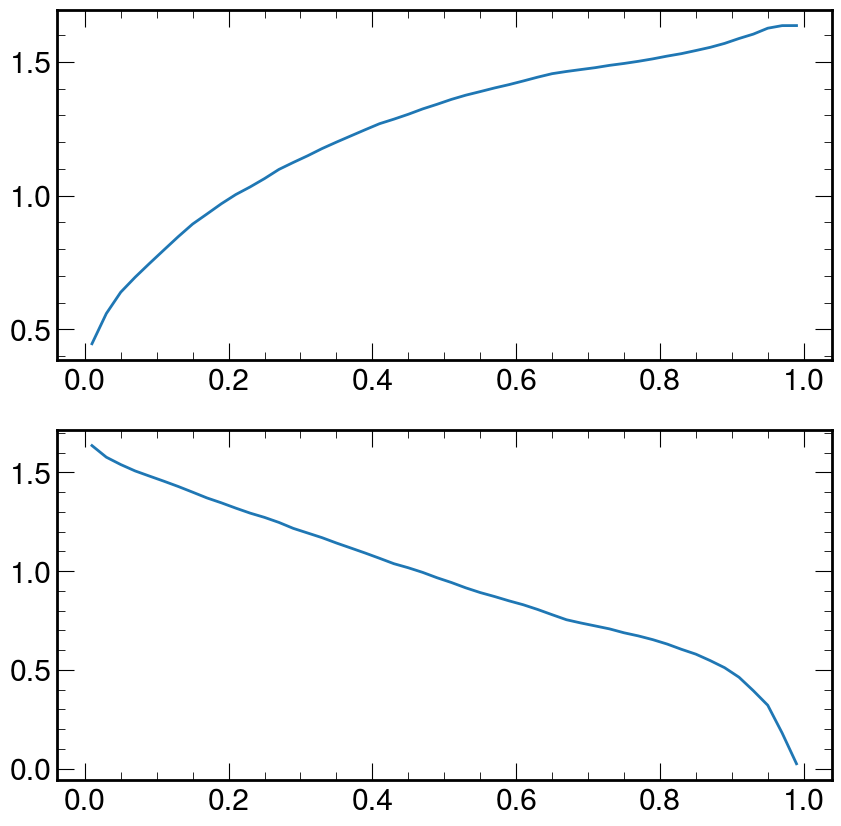

In [9]:
# significance curve
def signif(s, b):
    return np.sqrt(2*((s + b)*(np.log(1 + s/b)) - s))

hist_bkg = sum([contents[cname] for cname in categories_to_draw if cname.startswith("bkg")])
hist_sig = sum([contents[cname] for cname in categories_to_draw if cname.startswith("sig")])
x = hist.axes[0].centers
z_inv = signif(np.cumsum(hist_sig), np.cumsum(hist_bkg))
z = signif(np.cumsum(hist_sig[::-1])[::-1], np.cumsum(hist_bkg[::-1])[::-1])
# z_inv = np.nan_to_num(z_inv, nan=0)
# z = np.nan_to_num(z, nan=0)

fig, axs = plt.subplots(2, 1)
axs[0].plot(x, z_inv, label='Sig. (inv.)', linewidth=2)
axs[1].plot(x, z, label='Sig.', linewidth=2)
print(np.max(z_inv), np.max(z))

## Flavour-tagging uncertainties & Fit templates

In [10]:
# Assign the SF value from the SF tables depending on truth label, ftag region, and pT
ftag_sf = {
    "bjet": {
        "pt_edges": [20, 30, 40, 60, 100, 175, 250],
        "B1": [0.07, 0.04, 0.03, 0.01, 0.01, 0.02, 0.03],
        "B2": [0.07, 0.04, 0.03, 0.02, 0.03, 0.04, 0.08],
        "C1": [0.06, 0.03, 0.02, 0.02, 0.03, 0.06, 0.14],
        "C2": [0.05, 0.03, 0.01, 0.01, 0.02, 0.04, 0.10],
        "N":  [0.20, 0.12, 0.08, 0.05, 0.07, 0.08, 0.13],
    },
    "cjet": {
        "pt_edges": [20, 40, 65, 140],
        "B1": [0.10, 0.08, 0.08, 0.08],
        "B2": [0.10, 0.05, 0.05, 0.06],
        "C1": [0.10, 0.04, 0.04, 0.04],
        "C2": [0.07, 0.07, 0.06, 0.06],
        "N":  [0.07, 0.04, 0.04, 0.04],
    },
    "ljet": {
        "pt_edges": [20, 50, 100, 150],
        "B1": [0.23, 0.22, 0.24, 0.20],
        "B2": [0.22, 0.22, 0.25, 0.20],
        "C1": [0.12, 0.12, 0.13, 0.12],
        "C2": [0.13, 0.13, 0.13, 0.12],
        "N":  [0.0035, 0.0025, 0.0025, 0.0022],
    },
}
for sam in df:
    d = df[sam]

    # flatten the pT array
    jet_pt_flat = ak.flatten(d.jet_pt)
    counts = ak.num(d.jet_pt)

    # initiate SFs
    sf = np.zeros(len(jet_pt_flat))

    for flv in ["bjet", "cjet", "ljet"]:
        if flv == "bjet":
            truth_flag = (d.jet_flavor == 5)
        elif flv == "cjet":
            truth_flag = (d.jet_flavor == 4)
        else:
            truth_flag = (d.jet_flavor != 5) & (d.jet_flavor != 4)

        # for each truth flavour, assign the corresponding SF from the 5 regions and the corresponding SF table
        for ch in ["B1", "B2", "C1", "C2", "N"]:
            _idx = np.searchsorted(ftag_sf[flv]["pt_edges"], np.maximum(ak.to_numpy(jet_pt_flat), 20+1e-8)) - 1
            _sf = np.array(ftag_sf[flv][ch])[_idx]
            flag_flat = ak.flatten(truth_flag * getattr(d, f"jet_ftag_{ch}"))
            sf = sf + _sf * flag_flat

    df[sam]['jet_ftag_SF'] = ak.unflatten(sf, counts)

In [5]:
# Categories
from types import SimpleNamespace
config = SimpleNamespace(
    categories = { # category name: (sample list, selection, label, color)
        "bkg_wjets": (["wjets"], "d.lep_pt > 0", r"Bkg: W+jets", "lightcyan"),
        "bkg_t_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_t_matched", r"Bkg ($t_{bqq'}$)", "blue"),
        "bkg_w_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_w_matched", r"Bkg ($W_{qq'}$)", "red"),
        "bkg_tbc_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbc_matched", r"Bkg ($t_{bc}$)", "orange"),
        "bkg_tbq_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbq_matched", r"Bkg ($t_{bq'}$)", "wheat"),
        "bkg_non_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_non_matched", r"Bkg (non)", "lightyellow"),

        # signals
        "sig_t_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_t_matched", r"Sig ($t_{bqq'}$)", "blue"),
        "sig_w_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_w_matched", r"Sig ($W_{qq'}$)", "red"),
        "sig_tbc_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_tbc_matched", r"Sig ($t_{bc}$)", "orange"),
        "sig_tbq_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_tbq_matched", r"Sig ($t_{bq'}$)", "wheat"),
        "sig_non_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_non_matched", r"Sig (non)", "lightyellow"),

    },
    variables = {
        "evt_dnn_score": ("d.score_is_w_matched", bh.axis.Regular(100, 0, 1)),
        "sophon_discr2_dnn_hist2d": (("d.fj_sophon_discr2[:,0]", "d.score_is_w_matched"), (bh.axis.Regular(10, 0.9, 1), bh.axis.Regular(100, 0, 1))),
    },
    signal_mul_factor = 10,

    categories_merged = {
        "bkg_tbc": ["bkg_tbc_matched"],
        "bkg_others": ["bkg_wjets", "bkg_t_matched", "bkg_w_matched", "bkg_tbq_matched", "bkg_non_matched"],
        "sig": ["sig_t_matched", "sig_w_matched", "sig_tbc_matched", "sig_tbq_matched", "sig_non_matched"],
    }
)


In [ ]:

# cached df
dfc = {}
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        d = df[sam]
        dfc[(cname, sam)] = df[sam][eval(sel)]

In [12]:
xxx

NameError: name 'xxx' is not defined

In [ ]:
# make event DNN template

def make_flv_variation_template(target_flv, target_region, target_variation):

    assert target_flv in ["bjet", "cjet", "ljet"]
    assert target_region in ["B1", "B2", "C1", "C2", "N"]
    assert target_variation in ["up", "down", "nominal"]
    print(f"Making template for {target_flv} in {target_region} with {target_variation} variation")

    basesel_expr = "(d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)"

    # DNN cut
    # basesel_expr += " & (d.score_is_w_matched > 0.85)"

    varname = "sophon_discr2_dnn_hist2d"; do_plotting = True

    categories_to_draw = [
        "bkg_wjets",
        "bkg_t_matched", "bkg_w_matched", "bkg_tbc_matched", "bkg_tbq_matched", "bkg_non_matched",
        "sig_t_matched", "sig_w_matched", "sig_tbc_matched", "sig_tbq_matched", "sig_non_matched",
        ]

    varexpr, varaxis = config.variables[varname]
    assert isinstance(varexpr, tuple), "Only 2D hist is supported"

    print("Selection:", basesel_expr)
    print("Variable:", varexpr)

    def _concurrent_hist_filler(varaxis, var_array1, var_array2, weight_array, nthreads=1):
        def _fill_hist(input):
            vals1, vals2, weights = input
            hist = bh.Histogram(varaxis[0], varaxis[1], storage=bh.storage.Weight())
            hist.fill(vals1, vals2, weight=weights)
            return hist

        if nthreads == 1:
            return _fill_hist((var_array1, var_array2, weight_array))
        else:
            with ThreadPoolExecutor(nthreads) as pool:
                hist = pool.map(_fill_hist, zip(np.array_split(var_array1, nthreads), np.array_split(var_array2, nthreads), np.array_split(weight_array, nthreads)))
            hist = reduce(add, hist)
            return hist

    def _plotter(input):
        cname, sam = input
        # print('Processing', cname, sam)
        # base selection
        d = dfc[(cname, sam)]
        d = d[eval(basesel_expr)]
        # fill histogram
        var_array1 = eval(varexpr[0])
        var_array2 = eval(varexpr[1])

        ##### custom weight array #####
        target_flv_map = {
            "bjet": "d.jet_flavor == 5",
            "cjet": "d.jet_flavor == 4",
            "ljet": "(d.jet_flavor != 5) & (d.jet_flavor != 4)",
        }
        target_region_map = {
            'B1': "d.jet_ftag_B1",
            'B2': "d.jet_ftag_B2",
            'C1': "d.jet_ftag_C1",
            'C2': "d.jet_ftag_C2",
            'N': "d.jet_ftag_N",
        }

        cleanjet_flag = (d.jet_p4.deltaR(d.lep_p4) > 0.4) & (d.jet_p4.deltaR(d.fjcand_p4) > 0.8)
        flv_flag = eval(target_flv_map[target_flv])
        region_flag = eval(target_region_map[target_region])

        if target_variation == 'up':
            weight_array = ak.prod((1 + d.jet_ftag_SF)[cleanjet_flag & flv_flag & region_flag], axis=1)
        elif target_variation == 'down':
            weight_array = ak.prod((1 - d.jet_ftag_SF)[cleanjet_flag & flv_flag & region_flag], axis=1)
        else:
            weight_array = np.ones(len(d))
        ##### end custom weight array #####

        hist = _concurrent_hist_filler(varaxis, var_array1, var_array2, weight_array, nthreads=4)
        # yields within ... tbd
        yld = len(d[d.score_is_w_matched > 0.96])
        return hist, yld

    # generate inputs to send into concurrent plotter
    zipped_input = []
    for cname, (samlist, sel, label, color) in config.categories.items():
        for sam in samlist:
            zipped_input.append((cname, sam))

    # plotting
    if do_plotting:
        with ThreadPoolExecutor(2) as pool:
            results = dict(zip(zipped_input, pool.map(_plotter, zipped_input)))

    # retreive and group results for each category
    contents, variances, contents_mass_win = {}, {}, {}
    hists = {}
    for cname, (samlist, sel, label, color) in config.categories.items():
        _hists = []
        contents_mass_win[cname] = 0
        for sam in samlist:
            _hists.append(results[(cname, sam)][0] * weights[sam])
            contents_mass_win[cname] += results[(cname, sam)][1] * weights[sam]
        hists[cname] = sum(_hists)
        contents[cname], variances[cname] = hists[cname].view().value, hists[cname].view().variance
        # print(cname, round(contents_mass_win[cname], 1))

    templs = {}
    for cm in config.categories_merged:
        templs[cm] = sum([hists[cname] for cname in config.categories_merged[cm]])

    return templs

templs_summary = {}
for target_flv in ["bjet", "cjet", "ljet"]:
    for target_region in ["B1", "B2", "C1", "C2", "N"]:
        for target_variation in ["up", "down"]:
            templs_summary[f"{target_flv}_{target_region}_{target_variation}"] = make_flv_variation_template(target_flv, target_region, target_variation)
templs_summary["nom"] = make_flv_variation_template("bjet", "B1", "nominal")

Making template for bjet in B1 with up variation
Selection: (d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)
Variable: ('d.fj_sophon_discr2[:,0]', 'd.score_is_w_matched')
Making template for bjet in B1 with down variation
Selection: (d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)
Variable: ('d.fj_sophon_discr2[:,0]', 'd.score_is_w_matched')
Making template for bjet in B2 with up variation
Selection: (d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)
Variable: ('d.fj_sophon_discr2[:,0]', 'd.score_is_w_matched')
Making template for bjet in B2 with down variation
Selection: (d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)
Variable: ('d.fj_sophon_discr2[:,0]', 'd.score_is_w_matched')
Making template for bjet in C1 with up variation
Selection: (d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)
Variable: ('d.fj_sophon_discr2[:,0]', 'd.score_is_w_matched')
Making template for bjet in C1 with down variation
Selec

In [1]:
import pickle

# with open("pickles/wcb_ana_templ.pkl", "wb") as f:
#     pickle.dump((sig_templs, bkg_templs), f)
# with open("pickles/wcb_ana_templ_2dhist_spdiscr2.pkl", "wb") as f:
#     pickle.dump(templs_summary, f)
# with open("pickles/wcb_ana_templ_2dhist_spdiscr2_newbdt_lumi_100.pkl", "wb") as f: ## 25.02.08 new DNN including t_matched
#     pickle.dump(templs_summary, f)
    
with open("pickles/wcb_ana_templ_2dhist_spdiscr2_newbdt.pkl", "rb") as f: ## 25.02.08 new DNN including t_matched
    templs_summary = pickle.load(f)
# import pickle
# with open("pickles/wcb_ana_templ.pkl", "rb") as f:
#     sig_templs, bkg_templs = pickle.load(f)
# with open("pickles/wcb_ana_templ_2dhist_spdiscr2_newbdt.pkl", "rb") as f:
#     templs_summary = pickle.load(f)

# # verify the results: nominal histogram for sophon_discr2 > 0.95
# print(templs_summary["nom"]["sig"][5::bh.sum, :].values())
# print(sig_templs["nom"].values())

### Make the templates files

In [6]:
import copy
import numpy as np
start, end = 100, 4000
log_start, log_end = np.log10(start), np.log10(end)
log_points = np.linspace(log_start, log_end, 20)
points = np.power(10, log_points)
observation_list = []
for i, point in enumerate(points):
    
    filepath = f'./datacards/boosted/input_SR_no_{i}.root'
    aux_weight_scale = point / 450. # for HL-LHC
    _templs = copy.deepcopy(templs_summary) ## important!
    hist_out = {}
    # should first sum over the first Sophon discr index (start:end:bh.sum)
    for cm in config.categories_merged:
        hist_out[cm] = _templs["nom"][cm][5::bh.sum, :] ## important!

    for target_flv in ["bjet", "cjet", "ljet"]:
        for target_region in ["B1", "B2", "C1", "C2", "N"]:
            for target_variation in ["up", "down"]:
                _variation = "Up" if target_variation == "up" else "Down"
                for cm in config.categories_merged:
                    n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"
                    hist_out[n] = _templs[f"{target_flv}_{target_region}_{target_variation}"][cm][5::bh.sum, :] ## important!
                    # make sure the total yields doesn't change
                    hist_out[n].view().value *= sum(hist_out[cm].view().value) / sum(hist_out[n].view().value)
                    hist_out[n].view().variance *= (sum(hist_out[cm].view().value) / sum(hist_out[n].view().value))**2

    hist_out['data_obs'] = sum(hist_out[cm] for cm in config.categories_merged)

    # aux weight scale
    for n in hist_out:
        hist_out[n].view().value *= aux_weight_scale
        hist_out[n].view().variance *= aux_weight_scale**2

    # rebin the DNN score
    for n in hist_out:
        # hist_out[n] = hist_out[n][bh.loc(0.96):bh.loc(1.0):bh.rebin(4)] # 1 bin from 0.96--1
        # hist_out[n] = hist_out[n][bh.loc(0.88):bh.loc(1.0):bh.rebin(4)]
        hist_out[n] = hist_out[n][bh.loc(0.6):bh.loc(1.0):bh.rebin(4)]
        hist_out[n].view().variance *= 0
    
    print(f"id: {i}, lumi: {point}")
    print('Apply aux weight scale:', aux_weight_scale)
    print(hist_out['data_obs'].values().sum())
    print("\n")
    observation_list.append(hist_out['data_obs'].values().sum())
    # import ROOT
    # with uproot.recreate(filepath) as fw:
    #     for n in hist_out:
    #         fw[n] = hist_out[n]

id: 0, lumi: 100.0
Apply aux weight scale: 0.2222222222222222
334.0648157046043


id: 1, lumi: 121.42802934538574
Apply aux weight scale: 0.2698400652119683
405.64832244639564


id: 2, lumi: 147.44766310703878
Apply aux weight scale: 0.3276614735711973
492.570764019275


id: 3, lumi: 179.04279162670053
Apply aux weight scale: 0.39787287028155677
598.1189718801159


id: 4, lumi: 217.408133557268
Apply aux weight scale: 0.48312918568281776
726.2840806949073


id: 5, lumi: 263.9944122151748
Apply aux weight scale: 0.5866542493670551
881.9124466370771


id: 6, lumi: 320.56321233482146
Apply aux weight scale: 0.7123626940773811
1070.8889045030808


id: 7, lumi: 389.25359154443817
Apply aux weight scale: 0.8650079812098626
1300.3592932164806


id: 8, lumi: 472.66296536854884
Apply aux weight scale: 1.050362145263442
1579.0006641623602


id: 9, lumi: 573.9453242924919
Apply aux weight scale: 1.2754340539833153
1917.3493898429065


id: 10, lumi: 696.9304968083572
Apply aux weight scale: 1.5487

### Rewrite txt

In [23]:

with open("/home/pku/zhaoyz/pheno/notebooks/datacards/boosted/output/datacard.txt","r") as file:
    content = file.readlines()
    
for i, observation_value in enumerate(observation_list):
    # 替换 observation 行中的值
    new_content = []
    for line in content:
        if line.startswith("observation"):
            new_content.append(f"observation {observation_value}\n")
        else:
            new_content.append(line)
    
    # 将修改后的内容写入到新的文件中
    output_filename = f"/home/pku/zhaoyz/pheno/notebooks/datacards/boosted/no_{i}/datacard.txt"
    with open(output_filename, "w") as output_file:
        output_file.writelines(new_content)

### Plot the significance/unc as a function of LUMI

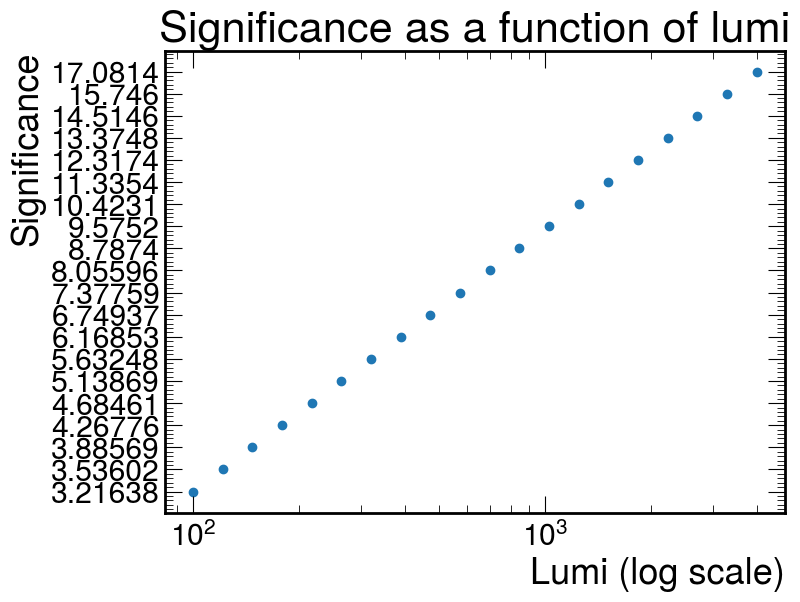

In [28]:
import os
import re

# 假设所有的txt文件都在一个文件夹中
folder_path = "/home/pku/zhaoyz/pheno/notebooks/datacards/boosted"  # 替换成你的文件夹路径
significance_values = []

# 遍历文件夹中的所有txt文件
for i in range(20):
    lumi = points[i]
    folder_path_i = f"{folder_path}/no_{i}"
# for filename in os.listdir(folder_path):
#     if filename.endswith(".txt"):  # 只处理以 .txt 结尾的文件
    filename = "TotalSignificance.txt"
    file_path = os.path.join(folder_path_i, filename)
    
    # 读取文件并查找Significance
    with open(file_path, "r") as file:
        content = file.read()
        
        # 使用正则表达式提取 Significance 后面的数字
        match = re.search(r"Significance:\s*([\d\.]+)", content)
        
        if match:
            significance_value = match.group(1)  # 提取数字
            significance_values.append((lumi, significance_value))

# 打印结果
# for filename, significance in significance_values:
#     print(f"File: {filename}, Significance: {significance}")

x_values, y_values = zip(*significance_values)

# 创建图形
plt.figure(figsize=(8, 6))

# 绘制点对，设置x轴为对数坐标
plt.scatter(x_values, y_values)

# 设置x轴为对数坐标
plt.xscale('log')

# 设置标签
plt.xlabel("Lumi (log scale)")
plt.ylabel("Significance")
plt.title("Significance as a function of lumi")

# 显示图形
plt.show()


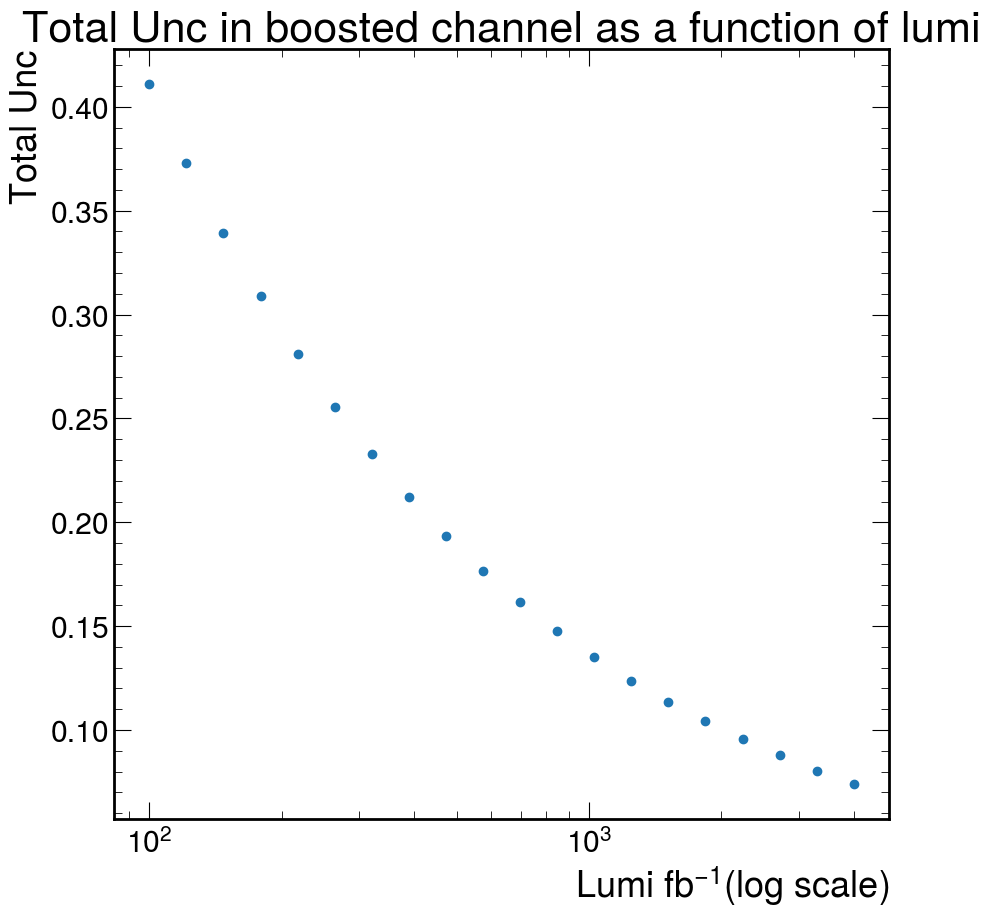

In [31]:
import os
import re

use_helvet = False  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)
    
# 假设所有的txt文件都在一个文件夹中
folder_path = "/home/pku/zhaoyz/pheno/notebooks/datacards/boosted"  # 替换成你的文件夹路径
errors = []

# 遍历文件夹中的所有txt文件
for i in range(20):
    lumi = points[i]
    folder_path_i = f"{folder_path}/no_{i}"
# for filename in os.listdir(folder_path):
#     if filename.endswith(".txt"):  # 只处理以 .txt 结尾的文件
    filename = "TotalUnc.txt"
    file_path = os.path.join(folder_path_i, filename)
    
    # 读取文件并查找Significance
    with open(file_path, "r") as file:
        content = file.read()
        
        # 使用正则表达式提取 Significance 后面的数字
        match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
        
        if match:
            down_error = float(match.group(1))
            up_error = float(match.group(2))
            
            # 计算误差的平均值
            average_error = (abs(down_error) + abs(up_error)) / 2
            errors.append((lumi, average_error))

# 打印结果
# for filename, significance in significance_values:
#     print(f"File: {filename}, Significance: {significance}")

x_values, y_values = zip(*errors)

# 创建图形
plt.figure(figsize=(10, 10))

# 绘制点对，设置x轴为对数坐标
plt.scatter(x_values, y_values)

# 设置x轴为对数坐标
plt.xscale('log')

# 设置标签
plt.xlabel(r"Lumi $fb^{-1}$(log scale)")
plt.ylabel("Total Unc")
plt.title("Total Unc in boosted channel as a function of lumi")

# 显示图形
plt.show()


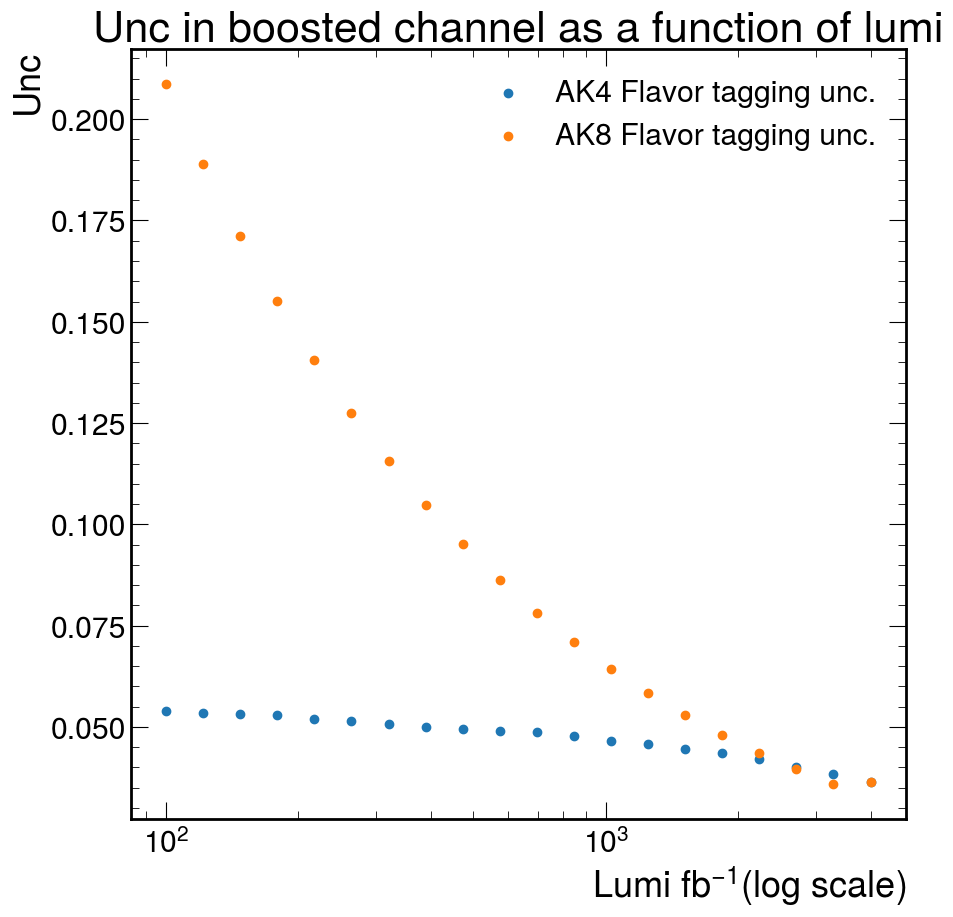

In [36]:
import os
import re

use_helvet = False  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)
    
# 假设所有的txt文件都在一个文件夹中
folder_path = "/home/pku/zhaoyz/pheno/notebooks/datacards/boosted"  # 替换成你的文件夹路径

ftag_averages = []
wcb_sf_averages = []

# 遍历文件夹中的所有txt文件
for i in range(20):
    lumi = points[i]
    folder_path_i = f"{folder_path}/no_{i}"
# for filename in os.listdir(folder_path):
#     if filename.endswith(".txt"):  # 只处理以 .txt 结尾的文件
    filename = "BreakDown.txt"
    file_path = os.path.join(folder_path_i, filename)
    
    # 读取文件并查找Significance
    with open(file_path, "r") as file:
        ftag_pattern = r"ftag:up:([\d\.\-]+), down: ([\d\.\-]+)"
        wcb_sf_pattern = r"wcb_sf:up:([\d\.\-]+), down: ([\d\.\-]+)"
        content = file.read()
        
        # 使用正则表达式提取 Significance 后面的数字
        match = re.search(r"r\s*:\s*[\+\-]?\d*\.\d+\s*-?([\d\.\+\-]+)\/\+?([\d\.\+\-]+)", content)
        
        ftag_match = re.search(ftag_pattern, content)
        if ftag_match:
            ftag_up = float(ftag_match.group(1))
            ftag_down = float(ftag_match.group(2))
            ftag_avg = (abs(ftag_up) + abs(ftag_down)) / 2  # 计算平均值
            ftag_averages.append((lumi,ftag_avg))
        # 提取 wcb_sf 的 up 和 down 值
        wcb_sf_match = re.search(wcb_sf_pattern, content)
        if wcb_sf_match:
            wcb_sf_up = float(wcb_sf_match.group(1))
            wcb_sf_down = float(wcb_sf_match.group(2))
            wcb_sf_avg = (abs(wcb_sf_up) + abs(wcb_sf_down)) / 2  # 计算平均值
            wcb_sf_averages.append((lumi,wcb_sf_avg))
        

# 打印结果
# for filename, significance in significance_values:
#     print(f"File: {filename}, Significance: {significance}")

x_values1, y_values1 = zip(*ftag_averages)
x_values2, y_values2 = zip(*wcb_sf_averages)

# 创建图形
plt.figure(figsize=(10, 10))

# 绘制点对，设置x轴为对数坐标
plt.scatter(x_values1, y_values1, label = "AK4 Flavor tagging unc.")
plt.scatter(x_values2, y_values2, label = "AK8 Flavor tagging unc.")

# 设置x轴为对数坐标
plt.xscale('log')
plt.legend()
# 设置标签
plt.xlabel(r"Lumi $fb^{-1}$(log scale)")
plt.ylabel("Unc")
plt.title("Unc in boosted channel as a function of lumi")

# 显示图形
plt.show()


In [ ]:
x

In [14]:
## write templates
filepath = './datacards/boosted/input_SR_450.root'
aux_weight_scale = 3000. / 450 # for HL-LHC
# aux_weight_scale = 1.

import copy
_templs = copy.deepcopy(templs_summary) ## important!

hist_out = {}
# should first sum over the first Sophon discr index (start:end:bh.sum)
for cm in config.categories_merged:
    hist_out[cm] = _templs["nom"][cm][5::bh.sum, :] ## important!

for target_flv in ["bjet", "cjet", "ljet"]:
    for target_region in ["B1", "B2", "C1", "C2", "N"]:
        for target_variation in ["up", "down"]:
            _variation = "Up" if target_variation == "up" else "Down"
            for cm in config.categories_merged:
                n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"
                hist_out[n] = _templs[f"{target_flv}_{target_region}_{target_variation}"][cm][5::bh.sum, :] ## important!
                # make sure the total yields doesn't change
                hist_out[n].view().value *= sum(hist_out[cm].view().value) / sum(hist_out[n].view().value)
                hist_out[n].view().variance *= (sum(hist_out[cm].view().value) / sum(hist_out[n].view().value))**2

hist_out['data_obs'] = sum(hist_out[cm] for cm in config.categories_merged)

# aux weight scale
for n in hist_out:
    hist_out[n].view().value *= aux_weight_scale
    hist_out[n].view().variance *= aux_weight_scale**2

# rebin the DNN score
for n in hist_out:
    # hist_out[n] = hist_out[n][bh.loc(0.96):bh.loc(1.0):bh.rebin(4)] # 1 bin from 0.96--1
    # hist_out[n] = hist_out[n][bh.loc(0.88):bh.loc(1.0):bh.rebin(4)]
    hist_out[n] = hist_out[n][bh.loc(0.6):bh.loc(1.0):bh.rebin(4)]
    hist_out[n].view().variance *= 0

print('Apply aux weight scale:', aux_weight_scale)
print(hist_out['data_obs'].values().sum())



Apply aux weight scale: 6.666666666666667
10021.94447113813


In [15]:
# import ROOT
with uproot.recreate(filepath) as fw:
    for n in hist_out:
        # values = hist_out[n].view().value[1:-1]  # 去掉头尾的 overflow 和 underflow
        # bin_edges = np.linspace(0.6, 1.0, 11)  # 设置 bin 边界，10 个 bin
        # hist = uproot.Histogram(
        #     bh.axis.Regular(len(bin_edges)-1, bin_edges[0], bin_edges[-1])  # 设置 bin 边界
        # )
        # hist.fill(*values)  # 使用 values 填充
        fw[n] = hist_out[n]

/tmp/ipykernel_601468/732350863.py:21: RuntimeWarning: invalid value encountered in divide
  [_templs[k].values() / sum(_templs[k].values()) / (_templs['nom'].values() / sum(_templs['nom'].values())) for k in keys],


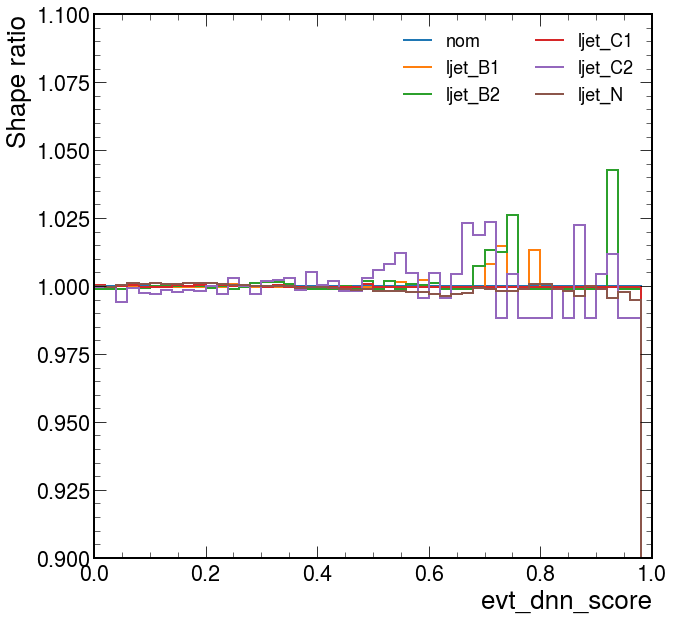

In [ ]:
## (optional) checks

import copy
_templs = copy.deepcopy(bkg_templs)

# rebin
for hname in _templs.keys():
    _templs[hname] = _templs[hname][::bh.rebin(2)]

flv = 'ljet'

keys = ["nom"] + [k for k in _templs if (k.startswith(flv) and k.endswith("up"))]

# plotting: stacked histogram
fig, ax = plt.subplots()
varname = "evt_dnn_score"
varexpr, varaxis = config.variables[varname]
hist = bh.Histogram(varaxis, storage=bh.storage.Weight())[::bh.rebin(2)]
hep.histplot(
    # [_templs[k] / sum(_templs[k]) for k in _templs if k == 'nom' or k.startswith('bjet')],
    [_templs[k].values() / sum(_templs[k].values()) / (_templs['nom'].values() / sum(_templs['nom'].values())) for k in keys],
    bins=hist.axes[0].edges,
    label=[k.replace('_up','') for k in keys],
    linewidth=2,
)

ax.set_xlim(varaxis.edges[0], varaxis.edges[-1])
ax.set_ylim(0.9, 1.1)
ax.set_xlabel(varname)
ax.set_ylabel("Shape ratio")
# ax.set_yscale("log")
ax.legend(prop={'size': 18}, loc='upper right', ncol=2)
plt.show()

array([ 15.35451402,  20.51162507,  28.60860263,  65.88572685,
       117.61897585, 152.45394406, 181.87496471, 219.33891674,
       213.37321251, 213.81687684, 224.20834336, 235.21092862,
       244.26852931, 245.37748367, 222.18611437, 200.6168344 ,
       208.31421036, 214.87453175, 223.099389  , 214.02307808,
       188.71585992, 182.81633954, 159.46295686, 176.66380749,
       156.84885843, 137.22456202, 140.18039105, 123.4148919 ,
       119.71557642, 122.27072673, 110.32281668,  97.36855019,
        72.10431763,  47.20280527,  27.59339427,  15.73923022,
        21.53789399,  10.768947  ,  14.08246915,  14.91084969,
        13.22706553,  10.768947  ,  13.25408861,   9.72671555,
        12.32485146,   6.19934249,   5.58481286,   1.65676108,
         0.        ,   0.        ])

In [ ]:
np.cumsum(hist_bkg[::-1])[::-1]

array([5.47270463e+03, 5.45735012e+03, 5.43683849e+03, 5.40822989e+03,
       5.34234416e+03, 5.22472519e+03, 5.07227124e+03, 4.89039628e+03,
       4.67105736e+03, 4.45768415e+03, 4.24386727e+03, 4.01965893e+03,
       3.78444800e+03, 3.54017947e+03, 3.29480199e+03, 3.07261587e+03,
       2.87199904e+03, 2.66368483e+03, 2.44881030e+03, 2.22571091e+03,
       2.01168783e+03, 1.82297197e+03, 1.64015563e+03, 1.48069267e+03,
       1.30402887e+03, 1.14718001e+03, 1.00995544e+03, 8.69775054e+02,
       7.46360162e+02, 6.26644585e+02, 5.04373859e+02, 3.94051042e+02,
       2.96682492e+02, 2.24578174e+02, 1.77375369e+02, 1.49781975e+02,
       1.34042744e+02, 1.12504850e+02, 1.01735903e+02, 8.76534343e+01,
       7.27425846e+01, 5.95155191e+01, 4.87465721e+01, 3.54924834e+01,
       2.57657679e+01, 1.34409164e+01, 7.24157394e+00, 1.65676108e+00,
       0.00000000e+00, 0.00000000e+00])

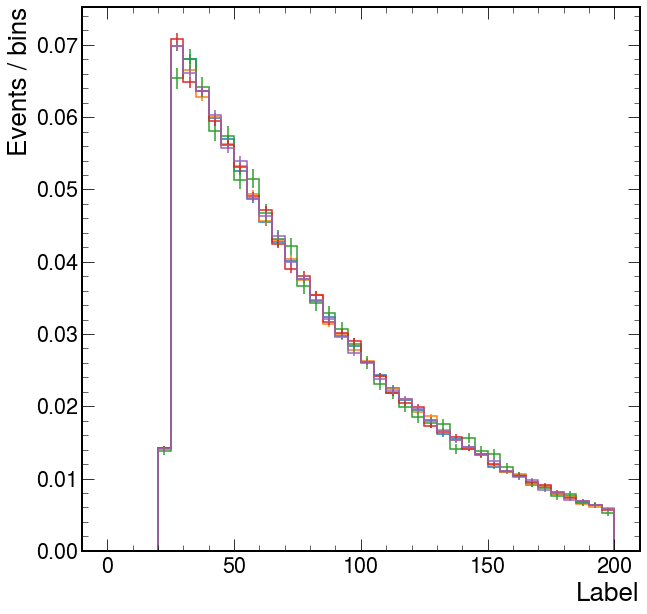

In [ ]:
f, ax = plt.subplots(figsize=(10,10))

nbin, xmin, xmax = 40, 0, 200

for i in ["1", "2", "3", "4", "5"]:
    hist = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())

    array = df0[i][(ak.num(df0[i].fj_pt) > 0) & (df0[i].lep_pid == -13)].lep_pt
    hist.fill(array)
    content, yerr = hist.view().value, np.sqrt(hist.view().variance)
    content, yerr = content / np.sum(content), yerr / np.sum(content)
    hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr, label=f"Part {i}")

ax.set_xlabel('Label', ha='right', x=1.0); ax.set_ylabel('Events / bins', ha='right', y=1.0);

In [ ]:
df = df0[i][ak.num(df0[i].fj_pt) > 0]

In [ ]:
a = ak.any(np.abs(df.genpart_pid[:, [3,4,8,9]]) == 5, axis=1)

In [ ]:
sum(df.is_wcb)

0

In [ ]:
for i in range(2000):
    print(f'sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_{i}.root')

sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_0.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_1.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_2.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_3.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_4.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_5.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_6.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_7.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_8.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_9.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_10.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_11.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_12.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_13.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_14.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_15.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_16.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_17.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_18.root
sm_1l_fjak15/WJetsToLN

In [ ]:
label_list = ["label_X_bb", "label_X_cc", "label_X_ss", "label_X_qq", "label_X_bc", "label_X_cs", "label_X_bq", "label_X_cq", "label_X_sq", "label_X_gg", "label_X_ee", "label_X_mm", "label_X_tauhtaue", "label_X_tauhtaum", "label_X_tauhtauh", "label_X_YY_bbbb", "label_X_YY_bbcc", "label_X_YY_bbss", "label_X_YY_bbqq", "label_X_YY_bbgg", "label_X_YY_bbee", "label_X_YY_bbmm", "label_X_YY_bbtauhtaue", "label_X_YY_bbtauhtaum", "label_X_YY_bbtauhtauh", "label_X_YY_bbb", "label_X_YY_bbc", "label_X_YY_bbs", "label_X_YY_bbq", "label_X_YY_bbg", "label_X_YY_bbe", "label_X_YY_bbm", "label_X_YY_cccc", "label_X_YY_ccss", "label_X_YY_ccqq", "label_X_YY_ccgg", "label_X_YY_ccee", "label_X_YY_ccmm", "label_X_YY_cctauhtaue", "label_X_YY_cctauhtaum", "label_X_YY_cctauhtauh", "label_X_YY_ccb", "label_X_YY_ccc", "label_X_YY_ccs", "label_X_YY_ccq", "label_X_YY_ccg", "label_X_YY_cce", "label_X_YY_ccm", "label_X_YY_ssss", "label_X_YY_ssqq", "label_X_YY_ssgg", "label_X_YY_ssee", "label_X_YY_ssmm", "label_X_YY_sstauhtaue", "label_X_YY_sstauhtaum", "label_X_YY_sstauhtauh", "label_X_YY_ssb", "label_X_YY_ssc", "label_X_YY_sss", "label_X_YY_ssq", "label_X_YY_ssg", "label_X_YY_sse", "label_X_YY_ssm", "label_X_YY_qqqq", "label_X_YY_qqgg", "label_X_YY_qqee", "label_X_YY_qqmm", "label_X_YY_qqtauhtaue", "label_X_YY_qqtauhtaum", "label_X_YY_qqtauhtauh", "label_X_YY_qqb", "label_X_YY_qqc", "label_X_YY_qqs", "label_X_YY_qqq", "label_X_YY_qqg", "label_X_YY_qqe", "label_X_YY_qqm", "label_X_YY_gggg", "label_X_YY_ggee", "label_X_YY_ggmm", "label_X_YY_ggtauhtaue", "label_X_YY_ggtauhtaum", "label_X_YY_ggtauhtauh", "label_X_YY_ggb", "label_X_YY_ggc", "label_X_YY_ggs", "label_X_YY_ggq", "label_X_YY_ggg", "label_X_YY_gge", "label_X_YY_ggm", "label_X_YY_bee", "label_X_YY_cee", "label_X_YY_see", "label_X_YY_qee", "label_X_YY_gee", "label_X_YY_bmm", "label_X_YY_cmm", "label_X_YY_smm", "label_X_YY_qmm", "label_X_YY_gmm", "label_X_YY_btauhtaue", "label_X_YY_ctauhtaue", "label_X_YY_stauhtaue", "label_X_YY_qtauhtaue", "label_X_YY_gtauhtaue", "label_X_YY_btauhtaum", "label_X_YY_ctauhtaum", "label_X_YY_stauhtaum", "label_X_YY_qtauhtaum", "label_X_YY_gtauhtaum", "label_X_YY_btauhtauh", "label_X_YY_ctauhtauh", "label_X_YY_stauhtauh", "label_X_YY_qtauhtauh", "label_X_YY_gtauhtauh", "label_X_YY_qqqb", "label_X_YY_qqqc", "label_X_YY_qqqs", "label_X_YY_bbcq", "label_X_YY_ccbs", "label_X_YY_ccbq", "label_X_YY_ccsq", "label_X_YY_sscq", "label_X_YY_qqbc", "label_X_YY_qqbs", "label_X_YY_qqcs", "label_X_YY_bcsq", "label_X_YY_bcs", "label_X_YY_bcq", "label_X_YY_bsq", "label_X_YY_csq", "label_X_YY_bcev", "label_X_YY_csev", "label_X_YY_bqev", "label_X_YY_cqev", "label_X_YY_sqev", "label_X_YY_qqev", "label_X_YY_bcmv", "label_X_YY_csmv", "label_X_YY_bqmv", "label_X_YY_cqmv", "label_X_YY_sqmv", "label_X_YY_qqmv", "label_X_YY_bctauev", "label_X_YY_cstauev", "label_X_YY_bqtauev", "label_X_YY_cqtauev", "label_X_YY_sqtauev", "label_X_YY_qqtauev", "label_X_YY_bctaumv", "label_X_YY_cstaumv", "label_X_YY_bqtaumv", "label_X_YY_cqtaumv", "label_X_YY_sqtaumv", "label_X_YY_qqtaumv", "label_X_YY_bctauhv", "label_X_YY_cstauhv", "label_X_YY_bqtauhv", "label_X_YY_cqtauhv", "label_X_YY_sqtauhv", "label_X_YY_qqtauhv", "label_QCD_bbccss", "label_QCD_bbccs", "label_QCD_bbcc", "label_QCD_bbcss", "label_QCD_bbcs", "label_QCD_bbc", "label_QCD_bbss", "label_QCD_bbs", "label_QCD_bb", "label_QCD_bccss", "label_QCD_bccs", "label_QCD_bcc", "label_QCD_bcss", "label_QCD_bcs", "label_QCD_bc", "label_QCD_bss", "label_QCD_bs", "label_QCD_b", "label_QCD_ccss", "label_QCD_ccs", "label_QCD_cc", "label_QCD_css", "label_QCD_cs", "label_QCD_c", "label_QCD_ss", "label_QCD_s", "label_QCD_light"]
for i in range(len(label_list)):
    print(i, f'"{label_list[i]}",')

0 "label_X_bb",
1 "label_X_cc",
2 "label_X_ss",
3 "label_X_qq",
4 "label_X_bc",
5 "label_X_cs",
6 "label_X_bq",
7 "label_X_cq",
8 "label_X_sq",
9 "label_X_gg",
10 "label_X_ee",
11 "label_X_mm",
12 "label_X_tauhtaue",
13 "label_X_tauhtaum",
14 "label_X_tauhtauh",
15 "label_X_YY_bbbb",
16 "label_X_YY_bbcc",
17 "label_X_YY_bbss",
18 "label_X_YY_bbqq",
19 "label_X_YY_bbgg",
20 "label_X_YY_bbee",
21 "label_X_YY_bbmm",
22 "label_X_YY_bbtauhtaue",
23 "label_X_YY_bbtauhtaum",
24 "label_X_YY_bbtauhtauh",
25 "label_X_YY_bbb",
26 "label_X_YY_bbc",
27 "label_X_YY_bbs",
28 "label_X_YY_bbq",
29 "label_X_YY_bbg",
30 "label_X_YY_bbe",
31 "label_X_YY_bbm",
32 "label_X_YY_cccc",
33 "label_X_YY_ccss",
34 "label_X_YY_ccqq",
35 "label_X_YY_ccgg",
36 "label_X_YY_ccee",
37 "label_X_YY_ccmm",
38 "label_X_YY_cctauhtaue",
39 "label_X_YY_cctauhtaum",
40 "label_X_YY_cctauhtauh",
41 "label_X_YY_ccb",
42 "label_X_YY_ccc",
43 "label_X_YY_ccs",
44 "label_X_YY_ccq",
45 "label_X_YY_ccg",
46 "label_X_YY_cce",
47 "label_